In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Question 1A
You will “train” a kNN classifier on the following training data:  

- The data is 2-dimensional points in a grid, such that the x1-coordinates and x2-coordinates both range
from −1.5 . . . 1.5, with a spacing of 0.1 between points.
- A training point, x = (x1, x2), will be classified as follows:
- Class 1 if kxk2 ≤ 1
- Class 2 otherwise  

Write code that generates this dataset and displays it using a scatterplot, using different colours for each
class.
Note kxkp = (x
p
1 + x
p
2
)
1
p can be implemented by: numpy.linalg.norm([x[0], x[1]], p)

In [126]:
#Question 1 

#Helper functions

def generate_dataset(data_points, norm_value):
    """
    Function to degenerate a dataset giiven number of datapoints and Norm Value
    data_points: number of datapoints 
    norm_value: the norm to use to create the datapoint
    
    returns an array 
    """
    x_coord = np.linspace(-1.5,1.5,30)
    y_coord = np.linspace(-1.5,1.5,30)

    x_coord_r = np.array(list(map(lambda x: round(x,1), x_coord)))
    y_coord_r = np.array(list(map(lambda x: round(x,1), y_coord)))

    x_list = [(random.choice(x_coord_r), random.choice(y_coord_r)) for i in range(data_points)]
    y_list = [1 if np.linalg.norm(point, norm_value) <= 1 else 2  for point in x_list]

    # create arrays
    data_x = np.array(x_list)
    data_y = np.array(y_list).reshape(data_points,1)
    data = np.concatenate((data_x, data_y), axis=1)
    
    return data

def plot_dataset_graph(train_data, test_data):
    """
    Function to plot a graph giving the train data and test data
    
    return: None 
    """
    #Separate the data based on their classes
    class1_train = train_data[train_data['y']==1]
    class2_train = train_data[train_data['y']==2]

    #check that the classes add up 
    assert len(class1_train) + len(class2_train) == len(train_data)

    #Graph Plotting
    # sns.scatterplot(x='x1', y='x2', hue='y', data=train_data)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])

    a = ax.scatter(class1_train['x1'], class1_train['x2'],  color='r')
    b = ax.scatter(class2_train['x1'], class2_train['x2'],  color='b')
    c = ax.scatter(test_data['x1'], test_data['x2'],  color='g')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Graph of X1 vs X2 \n class1=red, class2=blue. test=green')
#     ax.legend([a,b,c],['class1','class2','class3'], loc='upper left')

    
    return None

## Question 1A : Create Dataset 

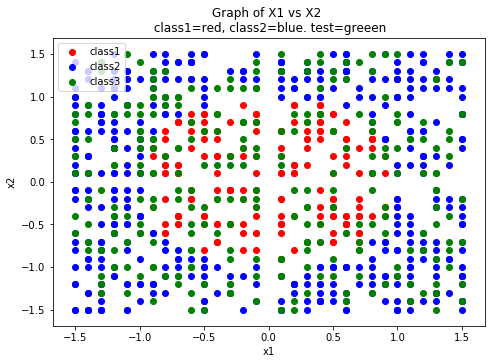

In [124]:

#create a 900 point dataset with norm value of 2
data_points = 900

data = generate_dataset(data_points=900, norm_value=2)

#Create dataframe from arrays
data = pd.DataFrame(data, columns=['x1','x2', 'y'])
data['y'] = data['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

# slice data in train_data and test_data (ration 70:30)
train_data = data[:int(0.7*data_points)]
test_data = data[-int(0.3*data_points):]

#plot graph
plot_dataset_graph(train_data, test_data)

In [4]:
#-- Organizing Data 
train_data_x = train_data[['x1','x2']]
train_data_y = train_data[['y']]

test_data_x = test_data[['x1','x2']]
test_data_y = test_data[['y']]


## Question 1B: Implement the KNN Algorithm

In [71]:
#KNN Class

class KNN:
    def __init__(self, k , num_classes, logger=False):
        """
        k = K Nearest neigbour k values
        num_classes = the number of label categories / classes
        logger: Boolean to determine if debug message will be printed to screen or not (optional)
                Only to help for troublshooting and coding processing progress!!!
        """
        self.num_classes = num_classes
        self.k = k
        self.logger = logger
        self.parameters = None
        
    def _calc_matrix_distance(self, matrix1, matrix2):
        """
        calculates the distance between two NX2 matrix
        returns: a NX1 matrix of the distances
        """

        flat_arr = np.linalg.norm(matrix1-matrix2, axis=1)
        return np.matrix(flat_arr).T
    
    def _get_majority_label(self, df):
        """
        Returns the majority label in a NX2 matrix where
        colums 1 are the distances
        column2 are the labels  
        returns: an int
        """
        df_label =  df[['label']].mode(axis=0)
        return df_label.values[0][0]
        
    def train(self, training_data, training_labels):
        """
        Train the classifier using the training data and training labels.
        Store whatever you think is neccessary in self.parameters.
        """
        self.parameters = None
        try:
            assert len(training_data) == len(training_labels)
        except:
            raise ValueError("Training Data and Training Label must be equal size!")
   
        #Santize the data
        if isinstance(training_data, pd.DataFrame):
            #convert to a matrix
            training_data = training_data.values
        if isinstance(training_labels, pd.DataFrame):
            #convert to a matrix
            training_labels = training_labels.values
            training_labels.reshape(-1,1)
            
        self.training_data = training_data
        self.training_labels = training_labels
        
        if self.logger == True:
            print("Training Size is: ", len(self.training_data))
           
    def predict(self, data):
        """
        Make use of the trained parameters to predict the class.
        Try using np.lingalg.norm() to compute distances.
        Input should be a LIST of d-dimensional points.
        The return value should be a LIST of scalars between 1 and num_classes,
        indicating for each input point how it is classified.
        """
        counter = 0
        total = len(data)
        
        if self.logger == True:
            print("Predict Size is: ", total)
        
        labels = list()
        for point in data:
            
            #convert point into a matrix that is the size of train data
            point = np.array(point)

            query_matrix = np.array([point] * self.training_data.shape[0])
    
            neighbour_distance_matrix = self._calc_matrix_distance(query_matrix, self.training_data)
            
            
            #combine neighbour matrix, training labels and distance for easier computation later
            df = pd.DataFrame(self.training_data)
            df['label'] = self.training_labels
            df['distance'] = neighbour_distance_matrix
            
            #sort frame in ascending order based on distance
            df.sort_values(by='distance', inplace=True)
            
            # get the K Neighbours and majority label
            neighbours = df[:self.k]
            label = self._get_majority_label(neighbours)
            labels.append(label)
            
            counter += 1
            if self.logger == True:
                if counter%20 == 0:
                    print(f'--- {counter} of {total} ---', end=' ' )

        self.predicted_labels = labels            
        return labels
                
    def accuracy(self, data, labels):
        """
        Returns the proportion of correct classifications computed over data.
        
        """
        assert len(data) == len(labels)
        
        #Santize the data
        if isinstance(data, pd.DataFrame):
            #convert to a matrix
            data = data.values
        if isinstance(labels, pd.DataFrame):
            #convert to a matrix
            labels = labels.values
            labels.reshape(-1,1)
        
        predict_labels = self.predict(data)
        
        predict_df = pd.DataFrame(predict_labels, columns=['predicted'])
        predict_df['actual'] = labels
        
        positives = sum(predict_df['actual'] == predict_df['predicted']) 
        
        acc = (positives / len(data)) * 100
        if self.logger == True:   
            print(f"Accuracy is: {acc}%")
            print("DONE")
        return (positives / len(data)) * 100
        

# Example use

# Initialize:
# myClassifier = KNN(k=1, num_classes=2)

# Train:
# some_train_data = [(1,1), (2,2), (1,-1), (-1,2)]
# some_train_labels = [1, 2, 1, 2]
# myClassifier.train(some_train_data, some_train_labels)

# Predict:
# predictions = myClassifier.predict([(-1,0), (3,3)])
# print(predictions) # prints [1, 2]

# Accuracy:
# acc = myClassifier.accuracy([(1,1), (2,2), (1,-1), (-1,2)], [1, 2, 1, 2])
# print(acc) # prints 1.0

###  Using the implemented alogrithm with TRAIN data


In [127]:
# -- Using the implemented alogrithm with TRAIN
# Expectation of 100% accuracy with K=1 !

myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)

accuracy_k1 = myClassifier.accuracy(train_data_x, train_data_y)
print("Accuracy with TRAIN Data and K=1 :", accuracy_k1)

#k=13
myClassifier = KNN(k=13, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)

accuracy_k13 = myClassifier.accuracy(train_data_x, train_data_y)

print("Accuracy with TRAIN Data K=13 :", accuracy_k13)

Accuracy with TRAIN Data and K=1 : 100.0
Accuracy with TRAIN Data K=13 : 98.57142857142858


###  Using the implemented alogrithm with TEST data


In [8]:
# Using the implemented alogrithm with TEST DATA

myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k1_test = myClassifier.accuracy(test_data_x, test_data_y)

print("Accuracy with TEST Data and K=1 :", accuracy_k1_test)

#k=13
myClassifier = KNN(k=13, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k13 = myClassifier.accuracy(test_data_x, test_data_y)
print("Accuracy with TEST Data K=13 :", accuracy_k13)

Accuracy with TEST Data and K=1 : 98.14814814814815
Accuracy with TEST Data K=13 : 98.14814814814815


##  Question 1C


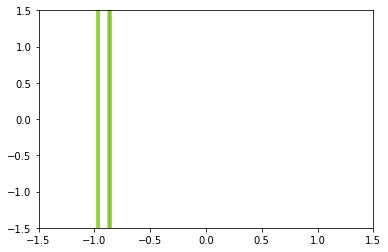

In [111]:
# Question 1C
x_c = np.linspace(-1.5, 1.5, 270)
y_c = x_c
x_c, y_c = np.meshgrid(x_c, y_c)

myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
predicted_y = myClassifier.predict(test_data_x.values)


# plt.contour(x_c, y_c, pred_actual[:30])
y_arr = np.array(predicted_y).T
y_arr = np.array([y_arr] * y_arr.shape[0])

plt.contour(x_c, y_c, y_arr)


## Question 1D
##### Try another data set.

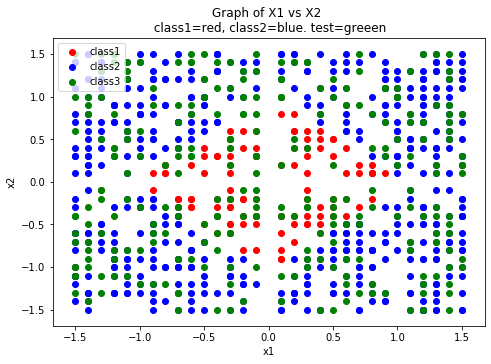

In [125]:
# Question 1D
#create a 900 point dataset with norm value of 1
data = generate_dataset(900, 1)


#Create dataframe from arrays
data = pd.DataFrame(data, columns=['x1','x2', 'y'])
data['y'] = data['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

# slice data in train_data and test_data (ration 70:30)
train_data = data[:int(0.7*data_points)]
test_data = data[-int(0.3*data_points):]

#plot graph
plot_dataset_graph(train_data,test_data )


organize data


In [10]:
#Question 1D
#organize data

train_data_x = train_data[['x1','x2']]
train_data_y = train_data[['y']]

test_data_x = test_data[['x1','x2']]
test_data_y = test_data[['y']]


### Using the implemented alogrithm with TRAIN DATA


In [15]:
#use the KNN classifier with train data

myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
myClassifier.predict([(0,0), [-0.4,1.3]])

accuracy_k1_train = myClassifier.accuracy(train_data_x, train_data_y)
print("Accuracy with K=1 :", accuracy_k1_train)

#k=13
myClassifier = KNN(k=13, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
myClassifier.predict([(0,0), [-0.4,1.3]])

accuracy_k13_train = myClassifier.accuracy(train_data_x, train_data_y)

print("Accuracyon train data with K=13 :", accuracy_k13_train)

Accuracy with K=1 : 100.0
Accuracyon train data with K=13 : 97.93650793650794


### Using the implemented alogrithm with TEST DATA


In [14]:
# Using the implemented alogrithm with TEST DATA

myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k1_test = myClassifier.accuracy(test_data_x, test_data_y)

print("Accuracy with TEST Data and K=1 :", accuracy_k1_test)

#k=13
myClassifier = KNN(k=13, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k13 = myClassifier.accuracy(test_data_x, test_data_y)
print("Accuracy with TEST Data K=13 :", accuracy_k13)

Accuracy with TEST Data and K=1 : 98.88888888888889
Accuracy with TEST Data K=13 : 99.25925925925925


# Trying Extreme value of k ( k = 100) on TEST data

In [16]:
#k=13
myClassifier = KNN(k=100, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
myClassifier.predict([(0,0), [-0.4,1.3]])

accuracy_k100_train = myClassifier.accuracy(train_data_x, train_data_y)

print("Accuracy on Test Data with K=100 :", accuracy_k100_train)

Accuracy on Test Data with K=100 : 90.95238095238095


### Remarks:
### Generally, as the value of K incresases, the Accuracy decreases!!! **


## Question 1E: Continue exploring data sets.

## create a 900 point dataset with norm value of 0.4

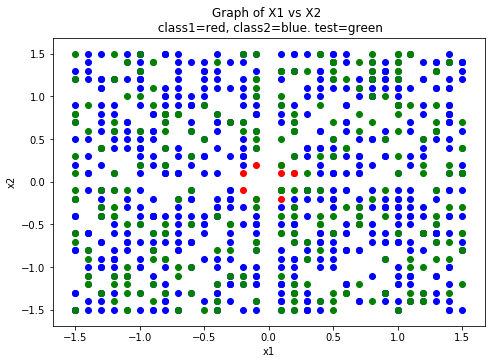

In [128]:
# Question 1E
#create a 900 point dataset with norm value of 0.4
data_1e = generate_dataset(900, 0.4)

#Create dataframe from arrays
data_df = pd.DataFrame(data_1e, columns=['x1','x2', 'y'])
data_df['y'] = data_df['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

# slice data in train_data and test_data (ratio 70:30)
train_data = data_df[:int(0.7*data_points)]
test_data = data_df[-int(0.3*data_points):]

plot_dataset_graph(train_data,test_data )

In [19]:
#organize data
train_data_x = train_data[['x1','x2']]
train_data_y = train_data[['y']]

test_data_x = test_data[['x1','x2']]
test_data_y = test_data[['y']]

#use KNN classifier
myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)

accuracy_k1 = myClassifier.accuracy(train_data_x, train_data_y)
print("Accuracy with TRAIN data and K=1 :", accuracy_k1)

#k=13
myClassifier = KNN(k=13, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
myClassifier.predict([(0,0), [-0.4,1.3]])

accuracy_k13 = myClassifier.accuracy(train_data_x, train_data_y)

print("Accuracy with TRAIN data and K=13 :", accuracy_k13)

Accuracy with TRAIN data and K=1 : 100.0
Accuracy with TRAIN data and K=13 : 98.57142857142858


In [21]:
##use KNN classifier on TEST data
#k=1
myClassifier = KNN(k=1, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k1 = myClassifier.accuracy(test_data_x, test_data_y)
print("Accuracy with TEST data and  K=1 :", accuracy_k1)

#k=50
myClassifier = KNN(k=50, num_classes=2)
myClassifier.train(train_data_x.values, train_data_y.values)
accuracy_k13 = myClassifier.accuracy(test_data_x, test_data_y)

print("Accuracy with TEST data and K=50 :", accuracy_k13)

Accuracy with TEST data and  K=1 : 100.0
Accuracy with TEST data and K=50 : 99.25925925925925


### As you can see above with a norm value of 0.4, and with k=50, the accuracy increases. 
### This tells us that the Euclidean distance for kNN is **NOT** always the best choice?

# Question 2

In [22]:
#  Helper functions
#  Please use these functions to properly prepare the data before feeding into the 
#  KNN classifier!

def prepare_test_set(data_frame, size):
    """
    function to prepare the Test data from a dataframe
    and separate it into X,and Y i.e test Data and Test labels
    
    X and Y are PYTHON LISTS types containing the image points and labels
    returns: a tuple of (X and Y)
    """
    y = np.array(data_frame['label']).reshape(-1,1)

    x = mnist_test.drop(columns='label')
    x = x.values
    
    x_size = [x[i] for i in range(size)]
    y_size = [y[i][0] for i in range(size)]
    
    return (x_size, y_size)

def prepare_train_set(data_frame, size):
    """
    function to prepare the TRAIN data from a dataframe
    and separate it into X,and Y i.e test Data and Test labels
    
    X and Y are NUMPY ARRAYS containing the image points and labels
    returns: a tuple of (X and Y)
    """
    x = np.array(data_frame.drop(columns='label'))
    y = np.array(data_frame['label']).reshape(-1,1)
    
    x_size = x[:size, :]
    y_size = y[:size,:]
    
    return (x_size, y_size)


## Load Train and Test Data

In [23]:
#load train data
mnist_train = pd.read_csv('data/mnist_train.csv', header=None)
mnist_train = mnist_train.rename(columns={0:'label'})

#load test data
mnist_test = pd.read_csv('data/mnist_test.csv', header=None)
mnist_test = mnist_test.rename(columns={0:'label'})

print("Train and Test data loaded succesfully!")

Train and Test data loaded succesfully!


In [25]:
# view the Train dataframes
mnist_train.head()


,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# view the Test dataframes
mnist_test.head()

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train Size and Test Size Variation.. Use this cell below to change your train size and test size anytime you wish to

** Use logger=True when using the KNN classifier to see debug output and know the progress of the classifier ** 

In [28]:
train_size = 6000
test_size = 500

In [29]:
# Prepare the Data

X_train, Y_train = prepare_train_set(mnist_train, train_size)
X_test, Y_test = prepare_test_set(mnist_test, test_size)


print("Train data size ==> ", X_train.shape)
print("Train label size ==>", Y_train.shape)
print("Test data size ==> ", len(X_test))
print("Test label size ==>", len(Y_test))


Train data size ==>  (6000, 784)
Train label size ==> (6000, 1)
Test data size ==>  500
Test label size ==> 500


In [72]:
myClassifier = KNN(k=1, num_classes=10, logger=True)
myClassifier.train(X_train, Y_train)

acc = myClassifier.accuracy(X_test, Y_test)

print("Accuracy on test set is: ", acc)

Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 92.0%
DONE
Accuracy on test set is:  92.0


## Question 2A: Explore k values.

Explore k values. Plot the classification accuracy on train and test sets by considering different
values of k in the range of 1 to 100.

In [129]:
#Question 1A
krange = [1, 5, 10, 20, 40, 80, 90, 100]
train_size = 10000
test_size = 100

X_train, Y_train = prepare_train_set(mnist_train, train_size)
X_test, Y_test = prepare_test_set(mnist_test, test_size)

print("Done Preparing Dataset! ")

lst = []
for k in krange:
    myClassifier = KNN(k=k, num_classes=10, logger=True)
    myClassifier.train(X_train, Y_train)
    acc = myClassifier.accuracy(X_test, Y_test)
    lst.append((k, acc))

print("done")

Done Preparing Dataset! 
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 92.0%
DONE
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 95.0%
DONE
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 96.0%
DONE
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 96.0%
DONE
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 92.0%
DONE
Training Size is:  10000
Predict Size is:  100
--- 20 of 100 --- --- 40 of 100 --- --- 60 of 100 --- --- 80 of 100 --- --- 100 of 100 --- Accuracy is: 89.0%
DONE
Tra

Text(0, 0.5, 'Accuracy')

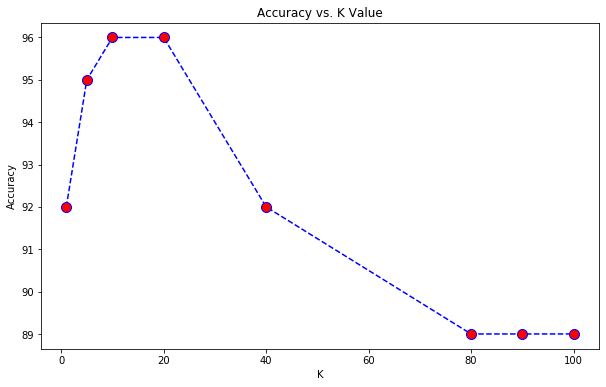

In [130]:
# Question 1a
lst
x, y = zip(*lst)
plt.figure(figsize=(10,6))
plt.plot(x,y,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

## Question 2B: Explore data set size.

In [74]:
# Question 1B

train_samples = [100, 200, 400, 600, 500, 1000, 10000, 30000, 60000]
test_size = 200
k = 20

X_test, Y_test = prepare_test_set(mnist_test, test_size)

print("Done Preparing Dataset! ")

lst_1b = []
for sample in train_samples:
    
    X_train, Y_train = prepare_train_set(mnist_train, sample)   
    myClassifier = KNN(k=k, num_classes=10, logger=True)
    myClassifier.train(X_train, Y_train)
    acc = myClassifier.accuracy(X_test, Y_test)
    lst_1b.append((sample, acc))


Done Preparing Dataset! 
Training Size is:  100
Predict Size is:  200
--- 20 of 200 --- --- 40 of 200 --- --- 60 of 200 --- --- 80 of 200 --- --- 100 of 200 --- --- 120 of 200 --- --- 140 of 200 --- --- 160 of 200 --- --- 180 of 200 --- --- 200 of 200 --- Accuracy is: 51.5%
DONE
Training Size is:  200
Predict Size is:  200
--- 20 of 200 --- --- 40 of 200 --- --- 60 of 200 --- --- 80 of 200 --- --- 100 of 200 --- --- 120 of 200 --- --- 140 of 200 --- --- 160 of 200 --- --- 180 of 200 --- --- 200 of 200 --- Accuracy is: 59.0%
DONE
Training Size is:  400
Predict Size is:  200
--- 20 of 200 --- --- 40 of 200 --- --- 60 of 200 --- --- 80 of 200 --- --- 100 of 200 --- --- 120 of 200 --- --- 140 of 200 --- --- 160 of 200 --- --- 180 of 200 --- --- 200 of 200 --- Accuracy is: 70.5%
DONE
Training Size is:  600
Predict Size is:  200
--- 20 of 200 --- --- 40 of 200 --- --- 60 of 200 --- --- 80 of 200 --- --- 100 of 200 --- --- 120 of 200 --- --- 140 of 200 --- --- 160 of 200 --- --- 180 of 200 --

Text(0, 0.5, 'Accuracy')

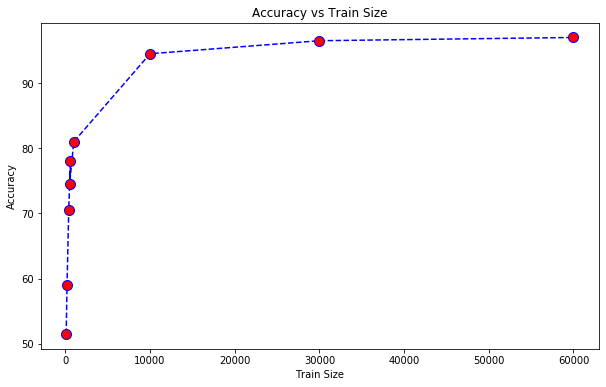

In [75]:
sample, acc = zip(*lst_1b)

plt.figure(figsize=(10,6))
plt.plot(sample, acc, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs Train Size')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')

### Remarks:  The greater the dataset size the greater the Accuracy!

# Question 3: The Curse of Dimensionality

#### Question 3A: Computing expectation in 2D.
Take two continuous random variables, X and Y , sampled
from a uniform distribution over the interval [0, 1]. Let Z be the squared Euclidean distance, defined by
Z = (X − Y )2 .   

Compute E[Z] and Var[Z] (this will require integration, which you can compute numericallyusing scipy.integrate.dblquad). Explain the integrals that you are computing.

In [115]:
from scipy import integrate

# X has range [0,1] and density function f(x) = 1
# y has range [0,1] and density function f(x) = 1

# E_Z = Expectation of EZ

f_xy = lambda x, y: (x-y)**2

E_Z = integrate.dblquad(f_xy, 0, 1, lambda x: 0, lambda x: 1)[0]
E_Z

0.16666666666666666

In [116]:
#VAR_Z = E(Z2) − E(Z)

f_xy_2 = lambda x, y: ((x-y)**2)**2
E_Z2 = integrate.dblquad(f_xy_2, 0, 1, lambda x: 0, lambda x: 1)[0]

VAR_Z = E_Z2 - E_Z**2

In [133]:
VAR_Z

0.0388888888888889

#### Question 3B: Computing expectation in n-D.
Take two continuous random variables, X and Y ,
sampled from a uniform distribution over the unit cube in d dimensions. That is, if X = (X1, X2, . . . , Xd)
then each Xi is uniformly sampled from [0, 1], independently from each other. The squared Euclidean distance can be written as R = Z1+Z2+· · ·+Zd, where Zi = (Xi−Yi)2  

Compute E[R] and Var[R]. You can write your
answers in terms of d, E[Z], and Var[Z]. Again, you may explore this question empirically/numerically.

In [132]:
def e_distance(x,y):
    """
    X = Matrix or vector
    Y = Matrix or vector
    """
    return sum((x-y)**2)

d = 2
# integrate.dblquad(e_distance, 0, 1, lambda x: 0, lambda x: 1)

    
    

# Question 4

In [36]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree

%matplotlib inline

In [37]:
#Helper functions from Question 1

def generate_dataset(data_points, norm_value):
    """
    Function to degenerate a dataset giiven number of datapoints and Norm Value
    data_points: number of datapoints 
    norm_value: the norm to use to create the datapoint
    
    returns an array 
    """
    x_coord = np.linspace(-1.5,1.5,30)
    y_coord = np.linspace(-1.5,1.5,30)

    x_coord_r = np.array(list(map(lambda x: round(x,1), x_coord)))
    y_coord_r = np.array(list(map(lambda x: round(x,1), y_coord)))

    x_list = [(random.choice(x_coord_r), random.choice(y_coord_r)) for i in range(data_points)]
    y_list = [1 if np.linalg.norm(point, norm_value) <= 1 else 2  for point in x_list]

    # create arrays
    data_x = np.array(x_list)
    data_y = np.array(y_list).reshape(data_points,1)
    data = np.concatenate((data_x, data_y), axis=1)
    
    return data

def split_test_train(dataframe, train_ratio, data_points):
    """
    function split data points into a ratio 
    data: Pandas dataFrame of data points
    train_ratio: ratio of train data between 0 and 1
    """
    if not 0 < train_ratio < 1:
        raise ValueError("Train ratio must be between 0 and 1")
    
    test_ratio = 1 - train_ratio
    
    # slice data in train_data and test_data (ration 70:30)
    train = dataframe[:int(train_ratio*data_points)]
    test = dataframe[-int(test_ratio*data_points):]

    #separate into X_train and Y_train i.e. data and label
    x_train = train.drop(columns='y')
    y_train = train[['y']]

    x_test = test.drop(columns='y')
    y_test = test[['y']]
    
    return (x_train, y_train, x_test, y_test )


def plot_dataset_graph(train_data, test_data):
    """
    Function to plot a graph giving the train data and test data
    
    return: None 
    """
    #Separate the data based on their classes
    class1_train = train_data[train_data['y']==1]
    class2_train = train_data[train_data['y']==2]

    #check that the classes add up 
    assert len(class1_train) + len(class2_train) == len(train_data)

    #Graph Plotting
    # sns.scatterplot(x='x1', y='x2', hue='y', data=train_data)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])

    a =ax.scatter(class1_train['x1'], class1_train['x2'],  color='r')
    b = ax.scatter(class2_train['x1'], class2_train['x2'],  color='b')
    c = ax.scatter(test_data['x1'], test_data['x2'],  color='g')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Graph of X1 vs X2')
    ax.legend([a,b,c],['class1','class2','class3'], loc='upper left')
    
    return None

# Question 4A
woring with datasets from question 1 and running DecisionTree alogorithm on the datapoints

### create a 900 point dataset with norm value of 1


In [38]:
#create a 900 point dataset with norm value of 1
data_points = 900

d1 = generate_dataset(data_points=900, norm_value=1)

#Create dataframe from arrays
d1 = pd.DataFrame(d1, columns=['x1','x2', 'y'])
d1['y'] = d1['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

x_train, y_train, x_test, y_test = split_test_train(d1, 0.7, data_points)

In [39]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [40]:
predictions = dtree.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.97      0.94      0.95        62
           2       0.98      0.99      0.99       208

    accuracy                           0.98       270
   macro avg       0.97      0.96      0.97       270
weighted avg       0.98      0.98      0.98       270



In [41]:
accuracy_100 = accuracy_score(y_test, predictions) *100
print(round(accuracy_100,2))

97.78


### create a 900 point dataset with norm value of 2


In [42]:
#create a 900 point dataset with norm value of 2
data_points = 900

d2 = generate_dataset(data_points=900, norm_value=2)

#Create dataframe from arrays
d2 = pd.DataFrame(d2, columns=['x1','x2', 'y'])
d2['y'] = d2['y'].apply(lambda x: int(x))  #  convert the column to an int dtype


x_train, y_train, x_test, y_test = split_test_train(d1, 0.7, data_points)    

In [43]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [44]:
predictions = dtree.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.97      0.94      0.95        62
           2       0.98      0.99      0.99       208

    accuracy                           0.98       270
   macro avg       0.97      0.96      0.97       270
weighted avg       0.98      0.98      0.98       270



In [45]:
accuracy_100 = accuracy_score(y_test, predictions) *100
print(round(accuracy_100,2))

97.78


### create a 900 point dataset with norm value of 0.5 


In [46]:
#create a 900 point dataset with norm value of 0.5
data_points = 900

d1 = generate_dataset(data_points=900, norm_value=1)

#Create dataframe from arrays
d1 = pd.DataFrame(d1, columns=['x1','x2', 'y'])
d1['y'] = d1['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

x_train, y_train, x_test, y_test = split_test_train(d1, 0.7, data_points)

In [47]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [48]:
predictions = dtree.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.95      0.94      0.95        65
           2       0.98      0.99      0.98       205

    accuracy                           0.97       270
   macro avg       0.97      0.96      0.96       270
weighted avg       0.97      0.97      0.97       270



In [49]:
accuracy_100 = accuracy_score(y_test, predictions) *100
print(round(accuracy_100,2))

97.41


### create a 900 point dataset with norm value of 0.1


In [50]:
#create a 900 point dataset with norm value of 0.1
data_points = 900

d1 = generate_dataset(data_points=900, norm_value=1)

#Create dataframe from arrays
d1 = pd.DataFrame(d1, columns=['x1','x2', 'y'])
d1['y'] = d1['y'].apply(lambda x: int(x))  #  convert the column to an int dtype

x_train, y_train, x_test, y_test = split_test_train(d1, 0.7, data_points)

In [51]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [52]:
predictions = dtree.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.89      0.93      0.91        44
           2       0.99      0.98      0.98       226

    accuracy                           0.97       270
   macro avg       0.94      0.95      0.95       270
weighted avg       0.97      0.97      0.97       270



In [53]:
accuracy_100 = accuracy_score(y_test, predictions) *100
print(round(accuracy_100,2))

97.04


# Question 4B
Write code (not using built-in sklearn functionality) to split MNIST the training set to get a validation
set. Then, using sklearn’s built-in DecisionTreeClassifier, write a function which tries 4-6 different
values for max depth and both information gain and Gini coefficient split criteria, and outputs the accuracies
on the train, on the validation, and on the test sets.  

What would be the meta-parameter settings that you
would normally choose? Note that usually you would not run the classifier on the test set! This is simply a
chance to experiment with (i.e. take a peek at) how the performance on the test set would change.  

Briefly summarize your observations, making sure to include clear description of any other meta-parameter choices
that you made.

In [55]:
def split_crossval_train(x, y, train_ratio):
    """
    function split data points into a ratio 
    x: train data
    y: train labels
    train_ratio: ratio of train data between 0 and 1
    
    returns a tuple (x_train, y_train, x_test, y_test)
    """
    if not 0 < train_ratio < 1:
        raise ValueError("Train ratio must be between 0 and 1")
    
    if len(x) != len(y):
        raise ValueError("Train sets must have equal rows")
    
    test_ratio = 1 - train_ratio
    size = len(x)
    
    # slice data in train_data and test_data 
    x_train = x[:int(train_ratio*size)]
    x_test = x[-int(test_ratio*size):]
    
    y_train = y[:int(train_ratio*size)]
    y_test = y[-int(test_ratio*size):]
    
    return (x_train, y_train, x_test, y_test )

In [56]:
#load train data
mnist_train = pd.read_csv('data/mnist_train.csv', header=None)
mnist_train = mnist_train.rename(columns={0:'label'})

#load test data
mnist_test = pd.read_csv('data/mnist_test.csv', header=None)
mnist_test = mnist_test.rename(columns={0:'label'})

print("Train and Test data loaded succesfully!")

Train and Test data loaded succesfully!


### Separate MNIST Train data into a Train data and Cross Validation Set

In [57]:
#separate data and labels
x = mnist_train.drop(columns='label')
y = mnist_train[['label']]

#split dataset into train and cross_val set in ratio(70%-30%) using out split_test_train function!
x_train, y_train, x_test_crossval, y_test_crossval = split_crossval_train(x, y, 0.7)

In [58]:
# prepare test data and test label
x_test = mnist_test.drop(columns='label')
y_test = mnist_test[['label']]

## Using Default values for DecisionTreeClassifier

In [59]:
dtree = DecisionTreeClassifier()
fit = dtree.fit(x_train, y_train)

In [60]:
# predictions on cross_val set

predictions_cross_val = dtree.predict(x_test_crossval)
accuracy_100 = accuracy_score(y_test_crossval, predictions_cross_val) *100
print(accuracy_100.round(2))

86.63


In [61]:
# predictions on test set

predictions_test = dtree.predict(x_test)
accuracy_100 = accuracy_score(y_test, predictions_test) *100
print(accuracy_100.round(2))

86.55


In [69]:
# tree.plot_tree(fit)

## Question 4B
#### Tree Classification based on different parameters of Max_depth and Criterion

In [65]:
def my_classify(max_depth, criterion):
    
    result =  {}
    dtree = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    dtree.fit(x_train, y_train)

    # predictions on cross_val set
    predictions_cross_val = dtree.predict(x_test_crossval)
    accuracy_100 = accuracy_score(y_test_crossval, predictions_cross_val) *100
    result['cross_val_set'] = round(accuracy_100, 2)
    # predictions on test set

    predictions_test = dtree.predict(x_test)
    accuracy_100 = accuracy_score(y_test, predictions_test) *100
    result['test_set'] = round(accuracy_100, 2)
    
    return result


def tree_variability_test(criterion, max_depths):
    
    result = {}
    
    for max_depth in max_depths:
        result[f'max_depth={max_depth}'] = my_classify(max_depth, criterion)
        print(f"----{max_depth}", end=" ")
    return result

### DecisonTreeClassifier with parameter Gini and Maxdepth values of 3, 6, 9 ,15, 50

In [68]:
tree_variability_test('gini', (3,6,9,15,50))

----3 ----6 ----9 ----15 ----50 

{'max_depth=3': {'cross_val_set': 44.61, 'test_set': 44.58},
 'max_depth=6': {'cross_val_set': 73.54, 'test_set': 73.29},
 'max_depth=9': {'cross_val_set': 83.66, 'test_set': 83.35},
 'max_depth=15': {'cross_val_set': 86.93, 'test_set': 86.79},
 'max_depth=50': {'cross_val_set': 86.61, 'test_set': 86.34}}

**Remarks: The greater the Max_depth value, the greater the Accuracy. This makes sense as the max_depth refers to the vertical height of the tree. so more decisions are being done to create a new leaf and node.**

### DecisonTreeClassifier with parameter Entropy and Maxdepth values of 3, 6, 9, 15, 50

In [67]:
tree_variability_test('entropy', (3,6,9,15,50))

----3 ----6 ----9 ----15 

{'max_depth=3': {'cross_val_set': 49.05, 'test_set': 48.06},
 'max_depth=6': {'cross_val_set': 75.68, 'test_set': 75.94},
 'max_depth=9': {'cross_val_set': 85.34, 'test_set': 85.7},
 'max_depth=15': {'cross_val_set': 87.06, 'test_set': 88.11}}

**Remarks: The greater the Max_depth value, the greater the Accuracy. This makes sense as the max_depth refers to the vertical height of the tree. so more decisions are being done to create a new leaf and node.**

meta-parameter settings i would recommend is to have the maximum depth value as greater as possible and using Entropy criterion